In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from numpy.polynomial import Polynomial

from src.image_process.image_io import LoadImage

import src.image_process.pre_process as prep

import src.image_process.mask.mask_getters as maget

from src.image_process.edp_center.center_optimization.opt_funcs import Area
from src.image_process.edp_center.centroid import get_centroid
from src.image_process.edp_center.center_optimization.optimization import optimize_center

from src.image_process.diffraction_pattern import eDiffractionPattern
from src.image_process.polar.polar_representation import PolarRepresentation
from src.image_process.polar.rotational_average import RotationalAverage

In [2]:
def expand_hole(precursor_mask: np.array, theta: np.array, angular_range_expansion) -> np.array:
    num_beams = round(angular_range_expansion*theta.shape[0]/360)

    expanded_hole_mask = precursor_mask.copy()
    for i in range(-num_beams, num_beams):
        rolled_mask = np.roll(precursor_mask, shift=i)
        expanded_hole_mask = np.logical_and(expanded_hole_mask, rolled_mask)

    return expanded_hole_mask.copy()

def compute_cyclic_shift( precursor_mask: np.array, theta: np.array, cyclic_shift) -> np.array:
    shift = np.argmin(np.abs((cyclic_shift % 360) - theta))
    return np.logical_and(precursor_mask, np.roll(precursor_mask, shift))

In [3]:
def find_ones_group_limits(arr):
    one_indexes = np.where(arr)[0]
    
    if arr[0] == 1 and arr[-1] == 1:
        for i, valid_index in enumerate(one_indexes):
            diff = one_indexes[i + 1] - valid_index

            if diff > 1:
                start = one_indexes[i + 1]
                end = valid_index
                
                return start, end
            
    start = one_indexes[0]
    end = one_indexes[-1]
    
    return start, end

def get_valid_theta_range(angular_mask, theta_space):
    start, end = find_ones_group_limits(angular_mask)

    return theta_space[start], theta_space[end]

In [4]:
def shrink_signal(sig, alpha):
    
    original_indices = np.arange(len(sig))
    
    new_indices = np.linspace(0, (len(sig) - 1) * alpha, len(sig))
    
    compressed_signal = np.interp(new_indices, original_indices, sig)
    
    return compressed_signal

In [5]:
def cos_dist(pk, qk):
    return 1 - np.dot(pk, qk) / (np.linalg.norm(pk) * np.linalg.norm(qk))

In [7]:
def distance(a, b):
    c = np.subtract(a, b)

    return np.linalg.norm(c)

In [8]:
import numpy as np

class ImagePadder:
    def __init__(self, data, center, max_radius=None):
        self._data = data
        self._center = center
        self._max_radius = max_radius
        self._up = None
        self._down = None
        self._right = None
        self._left = None
        self._square_data = None

    def _compute_max_radius(self):
        """Compute the maximum radius required for padding based on the corners."""
        if self._max_radius is None:
            corners = [
                (0, 0),  # Top-left
                (0, self._data.shape[1] - 1),  # Top-right
                (self._data.shape[0] - 1, 0),  # Bottom-left
                (self._data.shape[0] - 1, self._data.shape[1] - 1)  # Bottom-right
            ]
            # Calculate the maximum distance from the center to the corners
            self._max_radius = int(np.ceil(np.max([distance(self._center, corner) for corner in corners])))

    def _compute_pad_widths(self):
        """Compute the padding widths required on all four sides to center the image."""
        # Distances from the center to the borders
        self._up = max(0, self._max_radius - self._center[0])
        self._down = max(0, self._max_radius - (self._data.shape[0] - self._center[0] - 1))
        self._left = max(0, self._max_radius - self._center[1])
        self._right = max(0, self._max_radius - (self._data.shape[1] - self._center[1] - 1))

    def _compute_square_data(self):
        """Compute and store the square padded data."""
        self._compute_max_radius()
        self._compute_pad_widths()

        # Apply symmetric padding to create a square image centered on the desired point
        self._square_data = np.pad(
            self._data,
            pad_width=(
                (round(self._up), round(self._down)),  # Row padding (top, bottom)
                (round(self._left), round(self._right))   # Column padding (left, right)
            ),
            mode='wrap'
        )

    @property
    def square_data(self):
        """Return the square data, computing it if necessary."""
        if self._square_data is None:
            self._compute_square_data()
        return self._square_data
    
    @square_data.setter
    def square_data(self, new_data):
        self._square_data = new_data

    def recover_original_data(self):
        """Recover and return the original unpadded data from the square data."""
        original_data = self._square_data[
            round(self._up):round(self._square_data.shape[0] - self._down), 
            round(self._left):round(self._square_data.shape[1] - self._right)
        ]
        return original_data

In [9]:
def get_orthogonal_curves(angle: float, rotational_average: RotationalAverage):
    pk_angle = angle
    qk_angle = pk_angle + 90

    pk_angles = (pk_angle - semi_angle_range, pk_angle + semi_angle_range)
    qk_angles = (qk_angle - semi_angle_range, qk_angle + semi_angle_range)

    pk = rotational_average.get_rotational_average(*pk_angles)
    qk = rotational_average.get_rotational_average(*qk_angles)

    return pk, qk

In [10]:
def pre_process_curve(curve):
    tukey_window = signal.windows.tukey(curve.shape[0], alpha=1)

    return tukey_window * (signal.savgol_filter(curve, 5, 3))

In [11]:
from scipy.optimize import minimize_scalar

def elastic_divergence(pk, qk):

    min_func = lambda alpha: cos_dist(pk, shrink_signal(qk, alpha))

    result = minimize_scalar(min_func, method='Brent', bracket=(0.8, 1.2))

    return result.x
    

In [12]:
file_path = 'data/Ouro_beamstopper_final_Dia9_original.dm3'

load_image = LoadImage(file_path=file_path)

data = load_image.data

c:\Users\diego.nogueira\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [28]:
mean_mask = maget.MeanTreshMask(.1)
mask = maget.superpose_masks(data, [mean_mask])

In [29]:
penalty_func = Area(data, mask).get_penalty_func()
centroid = get_centroid(data)
center = optimize_center(penalty_func, data.shape, initial_guess=centroid)
center

(1413.9999966753064, 1370.9998495681673)

In [30]:
edp = eDiffractionPattern(data, center)
polar_representation = PolarRepresentation(edp=edp)

polar_representation.radial_range = (0.1, 0.6)

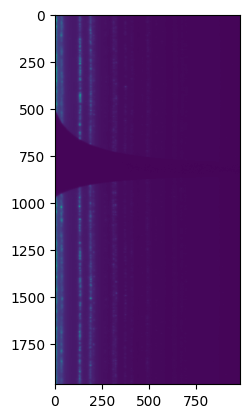

In [31]:
plt.imshow(polar_representation.polar_image)

# Proper mask getting

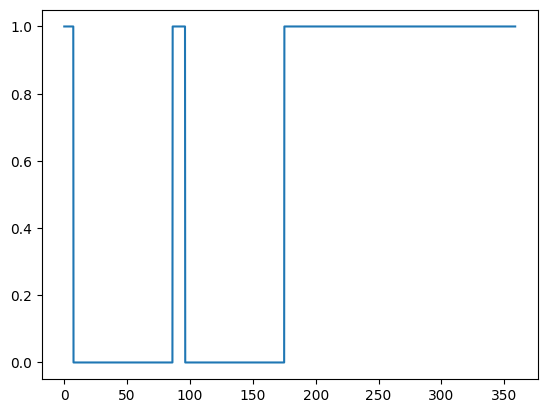

In [17]:
mask_edp = eDiffractionPattern(mask, center)
mask_polar_representation = PolarRepresentation(edp=mask_edp)

mask_polar_representation.radial_range = polar_representation.radial_range

angular_mask = mask_polar_representation.polar_image[:, 0]

semi_angle_range = 10

expanded_angular_mask = expand_hole(angular_mask, mask_polar_representation.theta, semi_angle_range)
expanded_angular_mask = compute_cyclic_shift(angular_mask, mask_polar_representation.theta, -90)

plt.plot(mask_polar_representation.theta, expanded_angular_mask)

# Elliptical Prameters Inference

In [18]:
theta_space = polar_representation.theta
divergences = []

rotational_average = RotationalAverage(polar_representation)

for angle in theta_space:
    pk, qk = get_orthogonal_curves(angle, rotational_average)

    pp_pk = pre_process_curve(pk)
    pp_qk = pre_process_curve(qk)

    divergence = elastic_divergence(pp_pk, pp_qk)
    divergences.append(divergence)

In [19]:
valid_theta, valid_divergences = theta_space[np.where(expanded_angular_mask)], np.array(divergences)[np.where(expanded_angular_mask)] - 1

In [20]:
from scipy.optimize import curve_fit

#amplitude = np.mean(np.abs(signal.hilbert(valid_divergences)))

def cos(thetas, amplitude, phase):
    return amplitude * np.cos(2 * (np.pi / 180 * thetas - (np.pi / 180) * phase))

bounds = ((0, -np.inf), (np.inf, np.inf))

params, _ = curve_fit(cos, valid_theta, valid_divergences, bounds=bounds)

amplitude, phase = params[0], params[1] % 90

print('Amplitude: {}, Phase: {}'.format(amplitude, phase))

Amplitude: 0.03539431420770019, Phase: 68.87046322578811


# Elliptical Correction

In [21]:
orientation = phase
sc_fac = 1+amplitude/2

orientation, sc_fac

(68.87046322578811, 1.01769715710385)

In [22]:
img_padder = ImagePadder(data, center)

data8 = img_padder.square_data.copy()

In [23]:
l = round((np.linalg.norm(data8.shape) - np.max(data.shape)) / 2)

data_for_rot = np.pad(data8.copy(), ((l, l), (l, l)), mode='constant', constant_values=0)

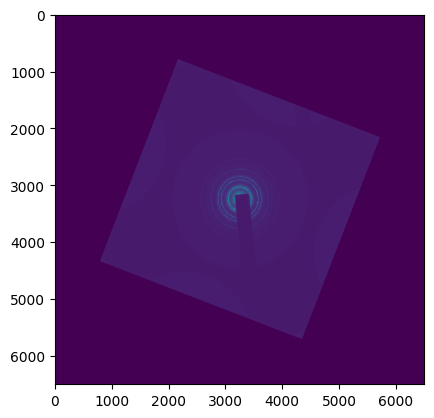

In [24]:
import cv2

M_semi = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), orientation, 1.0)
semi_rotated = cv2.warpAffine(data_for_rot.copy(), M_semi, data_for_rot.shape)

plt.imshow(semi_rotated)

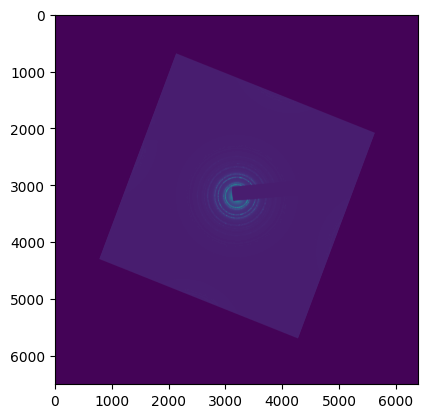

In [25]:
semi_corrected = cv2.resize(semi_rotated, (round(semi_rotated.shape[0]*sc_fac), semi_rotated.shape[1]), interpolation=cv2.INTER_CUBIC)

M = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), 90, 1.0)
rotated = cv2.warpAffine(semi_corrected, M, data_for_rot.shape)

corrected = cv2.resize(rotated, (round(rotated.shape[0]/sc_fac), rotated.shape[1]), interpolation=cv2.INTER_CUBIC)

plt.imshow(corrected)

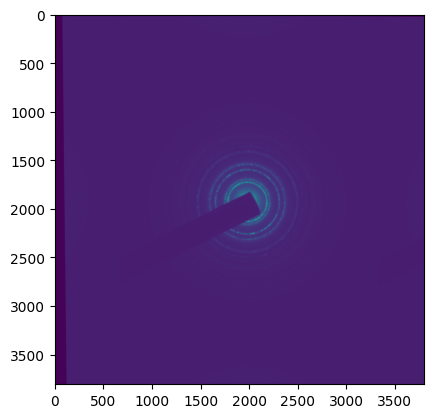

In [26]:
M_final = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), -(orientation+90), 1.0)
final_al = cv2.warpAffine(corrected.copy(), M_final, data_for_rot.shape)

final = final_al[l:l+data8.shape[0], l:l+data8.shape[0]]

plt.imshow(final)

# for testing

In [27]:
img_padder.square_data = final

data = img_padder.recover_original_data().copy()